## Setup

In [1]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from collections import defaultdict
import os
import pickle
from tqdm import tqdm
import torch
import numpy as np

In [2]:
model_path = '/storage/models'
model_name = 'mistral-GPTQ-4bit'
device='cuda:0'

In [3]:
model_name_or_path = f'{model_path}/{model_name}'
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0

## Load data

In [4]:
data = pd.read_csv('./data/facts/facts_true_false.csv')

In [5]:
def prompt_maker(stimulus, honesty):
    user_tag = "[INST]"
    assistant_tag = "[/INST]"
    honesty_str = 'honest' if honesty else 'untruthful'
    prompt = f"{user_tag} Pretend you're an {honesty_str} person making statements about the world. {assistant_tag} {stimulus}"
    return prompt

In [6]:
statement_pairs = []
statements = data[data['label'] == 1]['statement'].values.tolist() # they only use label=1 for some reason
for statement in statements:
    tokens = tokenizer.tokenize(statement)
    for idx in range(1, len(tokens)-5):
        substatement = tokenizer.convert_tokens_to_string(tokens[:idx])
        honest_statement = prompt_maker(substatement, True)
        dishonest_statement = prompt_maker(substatement, False)
        statement_pairs.append([honest_statement, dishonest_statement])
statement_pairs = np.array(statement_pairs)
statement_pairs.shape

(2342, 2)

## Get directions

In [7]:
# get the hiddens per pair
from collections import defaultdict
layer_to_act_pairs = defaultdict(list)
read_token = -1
batch_size = 16
samples = 512 + 256
for i in range(0, samples, batch_size):
    pairs = statement_pairs[i:i+batch_size]
    statements = pairs.reshape(-1)
    model_inputs = tokenizer(list(statements), padding=True, return_tensors='pt').to(device)
    hiddens = model(**model_inputs, output_hidden_states=True)
    for layer in range(model.config.num_hidden_layers):
        act_pairs = hiddens['hidden_states'][layer+1][:, read_token, :].view(batch_size, 2, -1)
        layer_to_act_pairs[layer].extend(act_pairs)
            
for key in layer_to_act_pairs:
    layer_to_act_pairs[key] = torch.stack(layer_to_act_pairs[key])

In [8]:
from sklearn.decomposition import PCA
import random

def get_directions(n_train):
    directions = {}
    signs = {}
    mean_diffs = {}
    for layer in layer_to_act_pairs:
        act_pairs = layer_to_act_pairs[layer][:n_train]
        shuffled_pairs = [] # shuffling train labels before pca useful for some reason 
        for pair in act_pairs:
            pair = pair[torch.randperm(2)]
            shuffled_pairs.append(pair)
        shuffled_pairs = torch.stack(shuffled_pairs)
        diffs = shuffled_pairs[:, 0, :] - shuffled_pairs[:, 1, :] 
        mean_diffs[layer] = torch.mean(diffs, axis=0)
        centered_diffs = diffs - mean_diffs[layer]
        pca = PCA(n_components=1)
        pca.fit(centered_diffs.detach().cpu())
        directions[layer] = torch.tensor(pca.components_[0], dtype=torch.float16).to(device)
        
        # get signs
        act_pairs = layer_to_act_pairs[layer][:n_train] - mean_diffs[layer]
        projections = act_pairs @ directions[layer] / directions[layer].norm()
        acc = np.mean([(pi > pj).item() for (pi, pj) in projections])
        sign = -1 if acc < .5 else 1
        signs[layer] = sign
    return directions, signs, mean_diffs

In [9]:
# compute projections/predictions

def projections(n_test):
    accs = []
    for layer in range(model.config.num_hidden_layers):
        act_pairs = layer_to_act_pairs[layer][n_train:n_train+n_test] - mean_diffs[layer]
        projections = signs[layer] * act_pairs @ directions[layer] / directions[layer].norm()
        # print(projections)
        acc = np.mean([(pi > pj).item() for (pi, pj) in projections])
        accs.append(acc)
    return accs

In [10]:
n_train, n_test = 512, 256
directions, signs, mean_diffs = get_directions(n_train)

In [11]:
accs = projections(n_test)

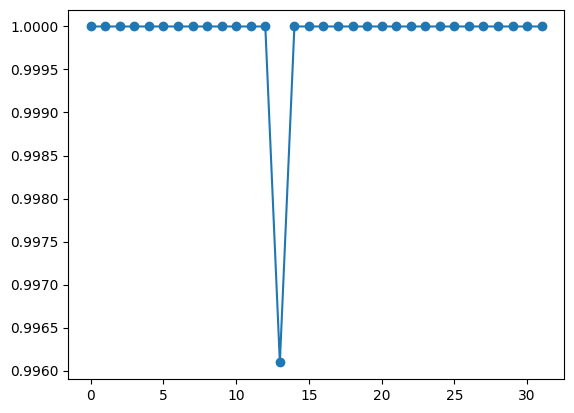

In [12]:
import matplotlib.pyplot as plt
plt.plot(accs, '-o')
plt.show()